# PART B - Keras - High Level API

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers

import numpy as np
import pandas as pd
import h5py
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from google.colab import drive
from google.colab import files

plt.style.use("default") # Set default layout for matplotlib's charts

print('All modules imported correctly')
print('Running TensorFlow version:', tf.__version__)

All modules imported correctly
Running TensorFlow version: 2.2.0-rc2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Mounting Google Drive from Colab to access the letters dataset
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Unzip and extract the file
!unzip "/content/gdrive/My Drive/Colab Notebooks/data.zip"

Archive:  /content/gdrive/My Drive/Colab Notebooks/data.zip
  inflating: data.h5                 


In [4]:
# Check the data has been extracted in my current workspace
!ls 

data.h5  gdrive  sample_data


**Helper functions for this notebook:**

In [0]:
def load_data():

  """ This function is given in the assignment spefication document:
  Read training and test data into NumPy arrays from a .h5 file. """

  with h5py.File('data.h5', 'r') as hf:

    # Extract the data from the .h5 file
    print('List of arrays in this file: \n', hf.keys())
    allTrain = hf.get('trainData')
    allTest = hf.get('testData')
    npTrain = np.array(allTrain)
    npTest = np.array(allTest)
    
    # Print shape of the arrays (n_images, n_features)
    print('Shape of the array dataset_1: \n', npTrain.shape)
    print('Shape of the array dataset_2: \n', npTest.shape)
  
  return npTrain[:,:-1], npTrain[:,-1], npTest[:,:-1], npTest[:,-1]

def plot_misclassified_images(n_examples, predicted_class, predicted_probability, testX, testY, save_fig=False):

  """ Select a random number of images in the test set that were classified incorreclty 
  and plot them horizontally annotating the actual and predicted class """

  image_size = round(1.2 * n_examples)
  class_examples = []
  # Get the index of the images misclassified
  errors_index = np.where(predicted_class != testY)[0]
  # Random selection of images
  misclassified = np.random.choice(errors_index, size=n_examples)
  f, position = plt.subplots(1, (n_examples), figsize=(image_size, image_size))
  # Plot selected images
  for image in range(n_examples):
    figure = position[image].\
     imshow(testX[misclassified[image],:].reshape(28, 28), # 28x28 images
            interpolation='nearest', 
            cmap = 'gray')
    # Hide axes
    figure.axes.get_xaxis().set_visible(False)
    figure.axes.get_yaxis().set_visible(False)
    # Annotate images with the corresponding class labes
    position[image].\
      text(14, 33, 'Actual: {}'.format(class_mapping[testY[misclassified[image]]]), fontsize=10,
       horizontalalignment='center', verticalalignment='center')
    position[image].\
      text(14, 39, 'Pred: {}'.format(class_mapping[predicted_class[misclassified[image]]]), fontsize=10,
       horizontalalignment='center', verticalalignment='center')
    position[image].\
      text(14, 45, 'Prob: {:.2%}'.format(predicted_probability[misclassified[image]]), fontsize=8,
       horizontalalignment='center', verticalalignment='center')
      
  if save_fig:
    plt.savefig('classification_errors.png', dpi=400, bbox_inches='tight')
    files.download('classification_errors.png')
    
  plt.show()

def plot_training_data(training_container, n_epochs, save_fig=False):

  """ Visualize the learning curves of a Neural Network.
  Plot up to 5 different metrics.  """
  
  # Get the keys of the container (metrics to be plotted)
  metrics = list(training_container.history.keys())
  # Map metrics to reporting names in charts 
  metrics_mapping = {'loss': 'Training Loss', 'accuracy': 'Training Accuracy', 
                     'val_loss': 'Validation Loss', 'val_accuracy': 'Validation Accuracy'}
  # Support for 5 different colors
  colors = ['dimgray', 'steelblue', 'salmon', 'darkseagreen', 'violet']

  if len(metrics) > 4:
    raise ValueError('This function can only plot up to 4 metrics.')
  
  # Plot a single linechart with all the training metrics
  plt.figure(figsize = (7,6))
  for metric in range(len(metrics)):
    plt.plot(np.arange(0, n_epochs), training_container.history[metrics[metric]], 
             label=metrics_mapping[metrics[metric]], color=colors[metric])
    plt.xticks(range(0,n_epochs), range(1,n_epochs+1))
    
  plt.legend()
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")

  if save_fig:
    plt.savefig('training_data.png', dpi=400, bbox_inches='tight')
    files.download('training_data.png')

  plt.show()

def summary_report(evaluation, testY, predicted_class, save_fig=False):

  """ Print a summary report including a confusion matrix given some test data. """

  # Print data resulting from Kera's evaluate method
  print(' ')
  print('****** SUMMARY REPORT ******')
  print('---------------------------')
  print('Loss on test set: {loss}'.format(loss=round(evaluation[0], 3)))
  print('Accuracy on test set: {accuracy}'.format(accuracy=round(evaluation[1], 3)))
  print('---------------------------')
  print('**** Confusion Matrix ****')
  print(' ')
  # Plot a heatmat using scikit-learn's confusion matrix function
  cm = confusion_matrix(testY, predicted_class)
  df_cm = pd.DataFrame(cm, index = list(class_mapping.values()),
                  columns = list(class_mapping.values()))
  plt.figure(figsize = (7,5))
  sn.heatmap(df_cm, cmap="Greys", annot=True, fmt='g')
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  if save_fig:
    plt.savefig('confusion_matrix.png', dpi=400, bbox_inches='tight')
    files.download('confusion_matrix.png')
  plt.plot()

def plot_models_loss(models, labels, n_epochs, loss='Validation', save_fig=False):
  
  """ Plot a linechart that compares the loss of a selection of 
  models at different training stages. """

  # Supporting up to 5 models and colors
  colors = ['dimgray', 'salmon', 'steelblue', 'darkseagreen', 'violet']
  if len(models) > 5:
      raise ValueError('This function can only plot up to 5 models.')

  if loss == 'Validation':
    requested = 'val_loss'
  elif loss == 'Training':
    requested = 'loss'
  else:
    raise ValueError('Please pick one of the following: Validation, Training.')

  l = 0 # Counter to select colors and labels      
  plt.figure(figsize = (7,6))
  for _model_ in models:
    plt.plot(_model_.history[requested], label=labels[l], color=colors[l])
    l += 1
  plt.xticks(range(0,n_epochs), range(1,n_epochs+1))
  plt.xlabel('Epoch #')
  plt.ylabel('Loss')
  plt.title('{} Loss'.format(loss))
  plt.legend()
  
  if save_fig:
    plt.savefig('models_loss.png', dpi=400,  bbox_inches='tight')
    files.download('models_loss.png' )

  plt.show()

## Part 1: Build and evaluate different network architectures

In [6]:
# Load the data and store it
trainX, trainY, testX, testY = load_data() 

List of arrays in this file: 
 <KeysViewHDF5 ['testData', 'trainData']>
Shape of the array dataset_1: 
 (200000, 785)
Shape of the array dataset_2: 
 (17000, 785)


In [7]:
# There are 10 different classes that are equally distributed in the training set:
unique_classes, count = np.unique(trainY, return_counts=True)
print('Class labels: ', unique_classes)
print('Number of training instances per class: ', count)

# Each class corresponds to a letter (from A to J)
class_mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}

Class labels:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Number of training instances per class:  [20000 20000 20000 20000 20000 20000 20000 20000 20000 20000]


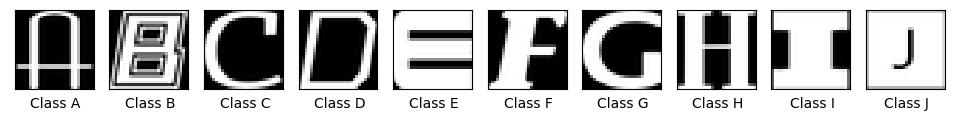

In [8]:
class_examples = []
for class_label in range(0, len(unique_classes)):
  class_examples.append(np.random.choice(np.where(trainY == class_label)[0], 1))

# Visualize 10 random images of the training set to get a "feel" of our classification problem
f, position = plt.subplots(1,len(unique_classes), figsize=(12,12))

for image in range(len(unique_classes)):
  figure = position[image].\
     imshow(trainX[class_examples[image],:].reshape(28, 28), # 28x28 images
            interpolation='nearest', 
            cmap = 'gray')
  # Hide axes
  figure.axes.get_xaxis().set_visible(False)
  figure.axes.get_yaxis().set_visible(False)
  # Annotate images with the corresponding class labes
  position[image].\
  text(14, 33, 'Class {}'.format(class_mapping[trainY[class_examples[image]][0]]), fontsize=10,
       horizontalalignment='center', verticalalignment='center')

# Uncomment to save images  
#plt.savefig('letters_examples.png', dpi=400, bbox_inches='tight')
#files.download('letters_examples.png')

plt.show()

### Softmax Classifier

In [9]:
# Softmax classifier
model = tf.keras.Sequential([
    layers.Dense(len(unique_classes), activation=tf.nn.softmax, input_shape=trainX[1,:].shape)
])

n_epochs = 20

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

softmax_history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=256, validation_split=0.1) 

Epoch 1/20
704/704 [==============================] - 2s 3ms/step - loss: 0.7474 - accuracy: 0.8022 - val_loss: 0.6596 - val_accuracy: 0.8249
Epoch 2/20
704/704 [==============================] - 2s 3ms/step - loss: 0.6526 - accuracy: 0.8279 - val_loss: 0.6456 - val_accuracy: 0.8266
Epoch 3/20
704/704 [==============================] - 2s 3ms/step - loss: 0.6409 - accuracy: 0.8309 - val_loss: 0.6405 - val_accuracy: 0.8281
Epoch 4/20
704/704 [==============================] - 2s 3ms/step - loss: 0.6346 - accuracy: 0.8319 - val_loss: 0.6364 - val_accuracy: 0.8304
Epoch 5/20
704/704 [==============================] - 2s 3ms/step - loss: 0.6312 - accuracy: 0.8330 - val_loss: 0.6366 - val_accuracy: 0.8292
Epoch 6/20
704/704 [==============================] - 2s 3ms/step - loss: 0.6294 - accuracy: 0.8333 - val_loss: 0.6345 - val_accuracy: 0.8302
Epoch 7/20
704/704 [==============================] - 2s 3ms/step - loss: 0.6269 - accuracy: 0.8342 - val_loss: 0.6338 - val_accuracy: 0.8308
Epoch 

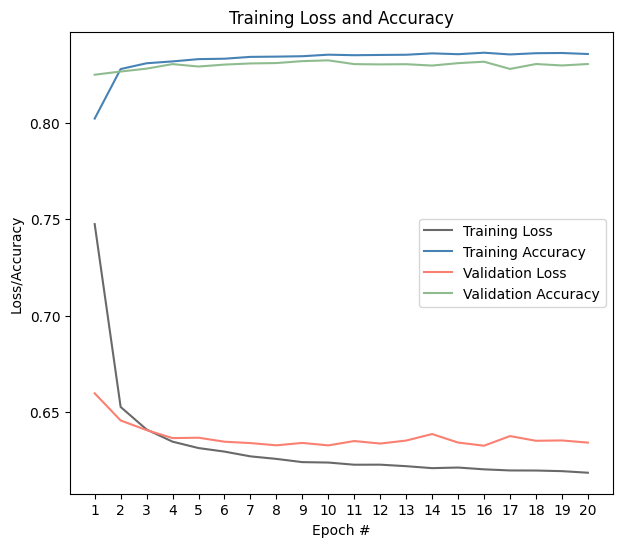

In [10]:
# Plot a linechart illustrating the NN's learning curves
plot_training_data(softmax_history, n_epochs, save_fig=False)

532/532 [==============================] - 1s 2ms/step - loss: 0.5494 - accuracy: 0.8541
 
****** SUMMARY REPORT ******
---------------------------
Loss on test set: 0.549
Accuracy on test set: 0.854
---------------------------
**** Confusion Matrix ****
 


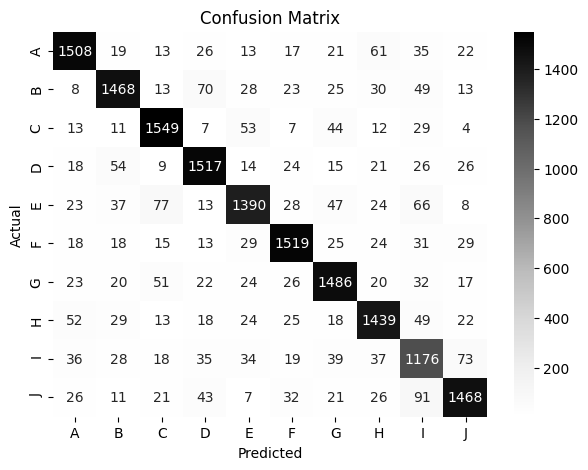

In [11]:
softmax_output = model.predict(testX) # Get the raw output of the network (softmax probabilities)
predicted_class = np.argmax(softmax_output, axis=1) # Store the class with highest probability
predicted_probability = np.amax(softmax_output, axis=1)  # Store the probability of the predicted class
result = model.evaluate(testX, testY) # Evaluate the model with Keras
summary_report(result, testY, predicted_class, save_fig=False) # Print the custom summary report

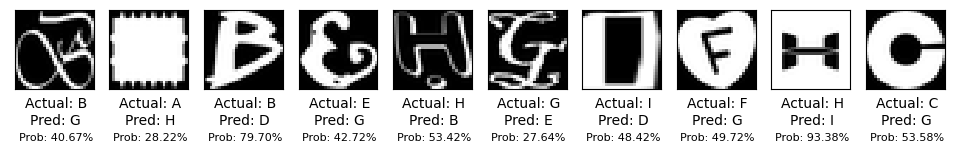

In [12]:
# Plot random 10 examples of misclassified images (you can run this cell muultiple times to see different examples)
plot_misclassified_images(10, predicted_class, predicted_probability, testX, testY, save_fig=False)

### Neural Network with 2 Layers - Relu & Softmax

In [13]:
# L1 200 Neurons L2 SoftMax

model = tf.keras.Sequential([
    layers.Dense(200, activation=tf.nn.relu, input_shape=trainX[1,:].shape),
    layers.Dense(len(unique_classes), activation=tf.nn.softmax)
])

n_epochs = 20

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

two_history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=256, validation_split=0.1)

Epoch 1/20
704/704 [==============================] - 2s 3ms/step - loss: 0.5308 - accuracy: 0.8465 - val_loss: 0.4598 - val_accuracy: 0.8651
Epoch 2/20
704/704 [==============================] - 2s 3ms/step - loss: 0.4116 - accuracy: 0.8803 - val_loss: 0.4113 - val_accuracy: 0.8818
Epoch 3/20
704/704 [==============================] - 2s 3ms/step - loss: 0.3684 - accuracy: 0.8919 - val_loss: 0.3927 - val_accuracy: 0.8873
Epoch 4/20
704/704 [==============================] - 2s 3ms/step - loss: 0.3420 - accuracy: 0.9004 - val_loss: 0.3895 - val_accuracy: 0.8892
Epoch 5/20
704/704 [==============================] - 2s 3ms/step - loss: 0.3217 - accuracy: 0.9059 - val_loss: 0.3781 - val_accuracy: 0.8941
Epoch 6/20
704/704 [==============================] - 2s 3ms/step - loss: 0.3045 - accuracy: 0.9106 - val_loss: 0.3841 - val_accuracy: 0.8903
Epoch 7/20
704/704 [==============================] - 2s 3ms/step - loss: 0.2902 - accuracy: 0.9148 - val_loss: 0.3800 - val_accuracy: 0.8962
Epoch 

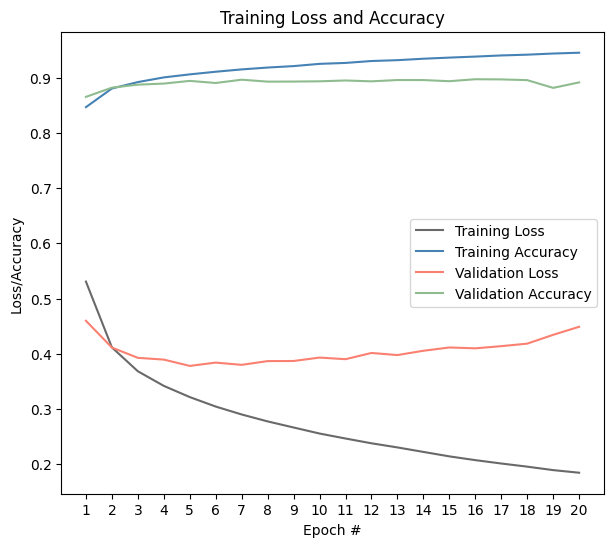

In [14]:
# Plot a linechart illustrating the NN's learning curves
plot_training_data(two_history, n_epochs, save_fig=False)

532/532 [==============================] - 1s 2ms/step - loss: 0.3576 - accuracy: 0.9099
 
****** SUMMARY REPORT ******
---------------------------
Loss on test set: 0.358
Accuracy on test set: 0.91
---------------------------
**** Confusion Matrix ****
 


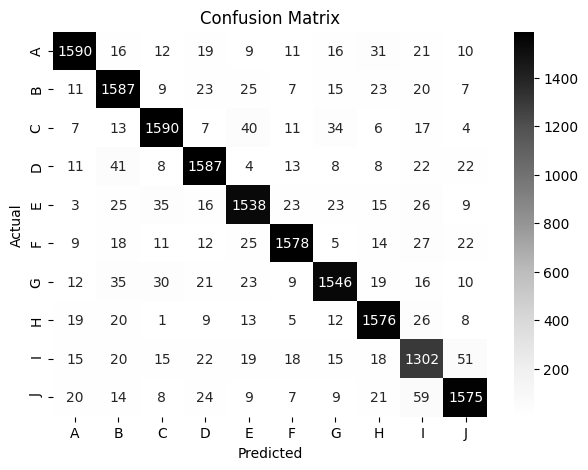

In [15]:
softmax_output = model.predict(testX) # Get the raw output of the network (softmax probabilities)
predicted_class = np.argmax(softmax_output, axis=1) # Store the class with highest probability
predicted_probability = np.amax(softmax_output, axis=1)  # Store the probability of the predicted class
result = model.evaluate(testX, testY) # Evaluate the model with Keras
summary_report(result, testY, predicted_class, save_fig=False) # Print the custom summary report

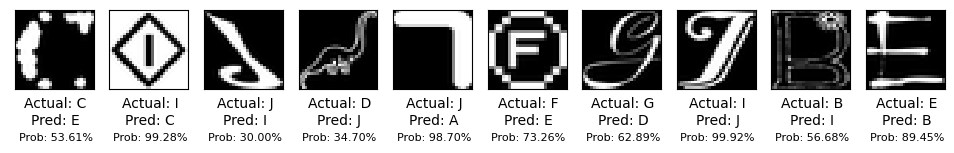

In [16]:
# Plot random 10 examples of misclassified images (you can run this cell muultiple times to see different examples)
plot_misclassified_images(10, predicted_class, predicted_probability, testX, testY, save_fig=False)

### Neural Network with 3 Layers - Relu & Softmax

In [17]:
# L1 400 Neurons L2 200 Neurons L3 SoftMax

model = tf.keras.Sequential([
    layers.Dense(400, activation=tf.nn.relu, input_shape=trainX[1,:].shape),
    layers.Dense(200, activation=tf.nn.relu),
    layers.Dense(len(unique_classes), activation=tf.nn.softmax)
])

n_epochs = 20

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

three_history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=256, validation_split=0.1)

Epoch 1/20
704/704 [==============================] - 2s 3ms/step - loss: 0.4759 - accuracy: 0.8581 - val_loss: 0.3989 - val_accuracy: 0.8817
Epoch 2/20
704/704 [==============================] - 2s 3ms/step - loss: 0.3536 - accuracy: 0.8927 - val_loss: 0.3628 - val_accuracy: 0.8904
Epoch 3/20
704/704 [==============================] - 2s 3ms/step - loss: 0.3070 - accuracy: 0.9058 - val_loss: 0.3482 - val_accuracy: 0.8967
Epoch 4/20
704/704 [==============================] - 2s 3ms/step - loss: 0.2750 - accuracy: 0.9150 - val_loss: 0.3399 - val_accuracy: 0.9006
Epoch 5/20
704/704 [==============================] - 2s 3ms/step - loss: 0.2483 - accuracy: 0.9225 - val_loss: 0.3389 - val_accuracy: 0.9015
Epoch 6/20
704/704 [==============================] - 2s 3ms/step - loss: 0.2253 - accuracy: 0.9290 - val_loss: 0.3402 - val_accuracy: 0.9024
Epoch 7/20
704/704 [==============================] - 2s 3ms/step - loss: 0.2027 - accuracy: 0.9359 - val_loss: 0.3466 - val_accuracy: 0.9024
Epoch 

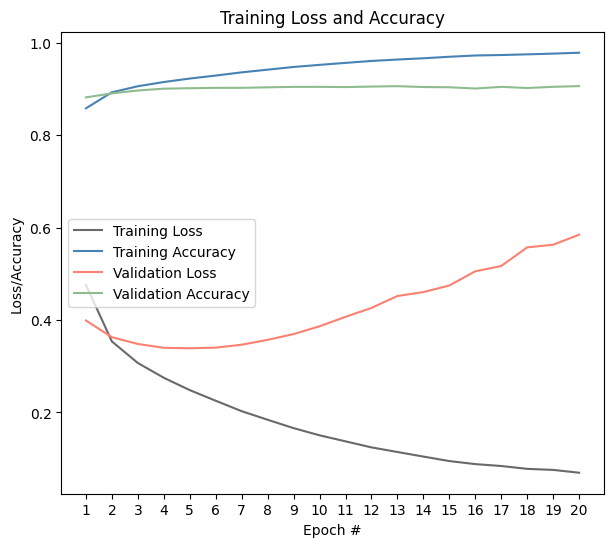

In [18]:
# Plot a linechart illustrating the NN's learning curves
plot_training_data(three_history, n_epochs, save_fig=False)

532/532 [==============================] - 1s 2ms/step - loss: 0.4596 - accuracy: 0.9249
 
****** SUMMARY REPORT ******
---------------------------
Loss on test set: 0.46
Accuracy on test set: 0.925
---------------------------
**** Confusion Matrix ****
 


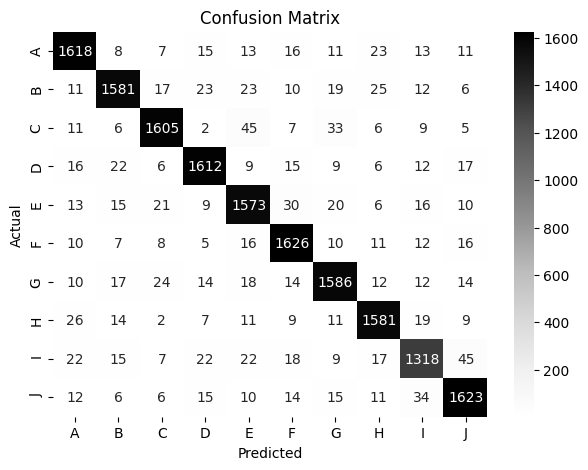

In [19]:
softmax_output = model.predict(testX) # Get the raw output of the network (softmax probabilities)
predicted_class = np.argmax(softmax_output, axis=1) # Store the class with highest probability
predicted_probability = np.amax(softmax_output, axis=1)  # Store the probability of the predicted class
result = model.evaluate(testX, testY) # Evaluate the model with Keras
summary_report(result, testY, predicted_class, save_fig=False) # Print the custom summary report

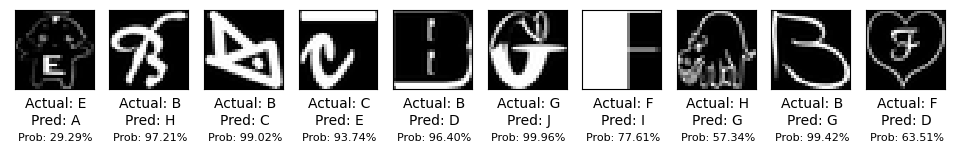

In [20]:
# Plot random 10 examples of misclassified images (you can run this cell muultiple times to see different examples)
plot_misclassified_images(10, predicted_class, predicted_probability, testX, testY, save_fig=False)

### Neural Network with 4 Layers - Relu & Softmax

In [21]:
# L1 600 Neurons L2 400 Neurons L3 200 Neurons L4 SoftMax

model = tf.keras.Sequential([
    layers.Dense(600, activation=tf.nn.relu, input_shape=trainX[1,:].shape),
    layers.Dense(400, activation=tf.nn.relu),
    layers.Dense(200, activation=tf.nn.relu),
    layers.Dense(len(unique_classes), activation=tf.nn.softmax)
])

n_epochs = 20

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

four_history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=256, validation_split=0.1)

Epoch 1/20
704/704 [==============================] - 2s 3ms/step - loss: 0.4572 - accuracy: 0.8612 - val_loss: 0.3887 - val_accuracy: 0.8817
Epoch 2/20
704/704 [==============================] - 2s 3ms/step - loss: 0.3371 - accuracy: 0.8951 - val_loss: 0.3541 - val_accuracy: 0.8906
Epoch 3/20
704/704 [==============================] - 2s 3ms/step - loss: 0.2906 - accuracy: 0.9085 - val_loss: 0.3420 - val_accuracy: 0.8960
Epoch 4/20
704/704 [==============================] - 2s 3ms/step - loss: 0.2578 - accuracy: 0.9180 - val_loss: 0.3318 - val_accuracy: 0.9007
Epoch 5/20
704/704 [==============================] - 2s 3ms/step - loss: 0.2292 - accuracy: 0.9266 - val_loss: 0.3330 - val_accuracy: 0.9064
Epoch 6/20
704/704 [==============================] - 2s 3ms/step - loss: 0.2045 - accuracy: 0.9340 - val_loss: 0.3522 - val_accuracy: 0.9054
Epoch 7/20
704/704 [==============================] - 2s 3ms/step - loss: 0.1825 - accuracy: 0.9411 - val_loss: 0.3473 - val_accuracy: 0.9050
Epoch 

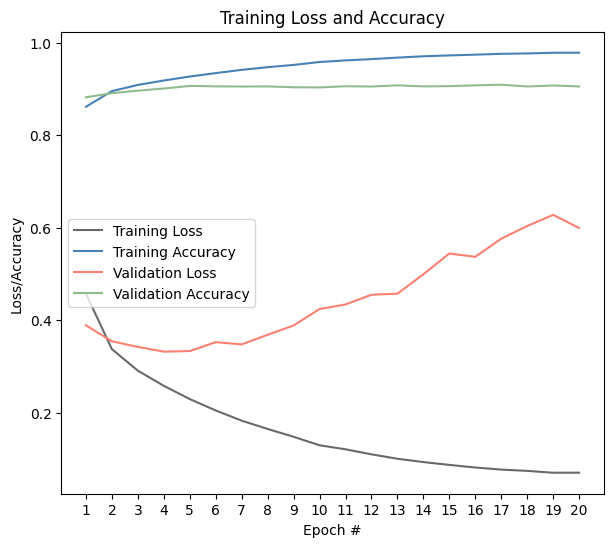

In [22]:
# Plot a linechart illustrating the NN's learning curves
plot_training_data(four_history, n_epochs, save_fig=False)

532/532 [==============================] - 1s 2ms/step - loss: 0.4582 - accuracy: 0.9256
 
****** SUMMARY REPORT ******
---------------------------
Loss on test set: 0.458
Accuracy on test set: 0.926
---------------------------
**** Confusion Matrix ****
 


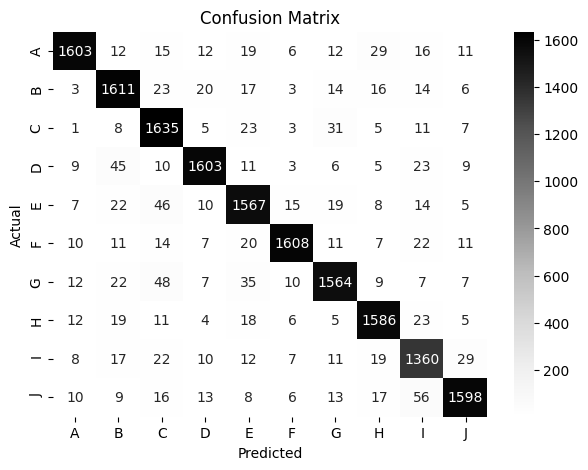

In [23]:
softmax_output = model.predict(testX) # Get the raw output of the network (softmax probabilities)
predicted_class = np.argmax(softmax_output, axis=1) # Store the class with highest probability
predicted_probability = np.amax(softmax_output, axis=1)  # Store the probability of the predicted class
result = model.evaluate(testX, testY) # Evaluate the model with Keras
summary_report(result, testY, predicted_class, save_fig=False) # Print the custom summary report

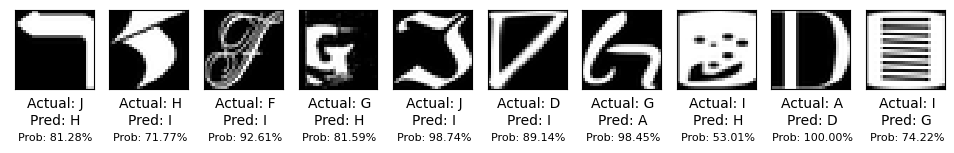

In [24]:
# Plot random 10 examples of misclassified images (you can run this cell muultiple times to see different examples)
plot_misclassified_images(10, predicted_class, predicted_probability, testX, testY, save_fig=False)

### Neural Network with 5 Layers - Relu & Softmax

In [25]:
# L1 600 Neurons L2 400 Neurons L3 200 Neurons L4 SoftMax

model = tf.keras.Sequential([
    layers.Dense(800, activation=tf.nn.relu, input_shape=trainX[1,:].shape),
    layers.Dense(600, activation=tf.nn.relu),
    layers.Dense(400, activation=tf.nn.relu),
    layers.Dense(200, activation=tf.nn.relu),
    layers.Dense(len(unique_classes), activation=tf.nn.softmax)
])

n_epochs = 20

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

five_history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=256, validation_split=0.1)

Epoch 1/20
704/704 [==============================] - 2s 3ms/step - loss: 0.4593 - accuracy: 0.8595 - val_loss: 0.3900 - val_accuracy: 0.8804
Epoch 2/20
704/704 [==============================] - 2s 3ms/step - loss: 0.3409 - accuracy: 0.8932 - val_loss: 0.3534 - val_accuracy: 0.8913
Epoch 3/20
704/704 [==============================] - 2s 3ms/step - loss: 0.2950 - accuracy: 0.9069 - val_loss: 0.3428 - val_accuracy: 0.8976
Epoch 4/20
704/704 [==============================] - 2s 3ms/step - loss: 0.2600 - accuracy: 0.9172 - val_loss: 0.3303 - val_accuracy: 0.9006
Epoch 5/20
704/704 [==============================] - 2s 3ms/step - loss: 0.2352 - accuracy: 0.9249 - val_loss: 0.3341 - val_accuracy: 0.9059
Epoch 6/20
704/704 [==============================] - 2s 3ms/step - loss: 0.2099 - accuracy: 0.9317 - val_loss: 0.3465 - val_accuracy: 0.9054
Epoch 7/20
704/704 [==============================] - 2s 3ms/step - loss: 0.1889 - accuracy: 0.9382 - val_loss: 0.3453 - val_accuracy: 0.9062
Epoch 

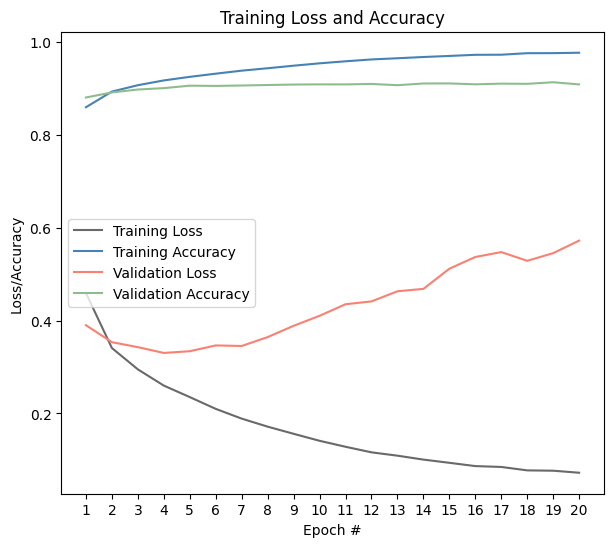

In [26]:
# Plot a linechart illustrating the NN's learning curves
plot_training_data(five_history, n_epochs, save_fig=False)

532/532 [==============================] - 1s 2ms/step - loss: 0.4313 - accuracy: 0.9277
 
****** SUMMARY REPORT ******
---------------------------
Loss on test set: 0.431
Accuracy on test set: 0.928
---------------------------
**** Confusion Matrix ****
 


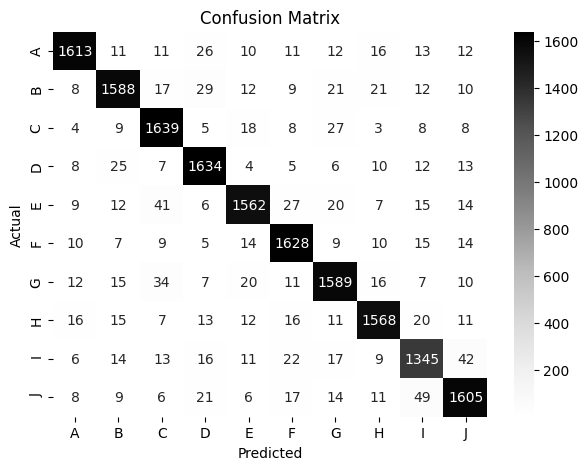

In [27]:
softmax_output = model.predict(testX) # Get the raw output of the network (softmax probabilities)
predicted_class = np.argmax(softmax_output, axis=1) # Store the class with highest probability
predicted_probability = np.amax(softmax_output, axis=1)  # Store the probability of the predicted class
result = model.evaluate(testX, testY) # Evaluate the model with Keras
summary_report(result, testY, predicted_class, save_fig=False) # Print the custom summary report

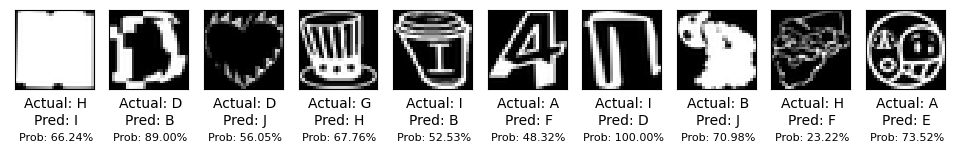

In [28]:
# Plot random 10 examples of misclassified images (you can run this cell muultiple times to see different examples)
plot_misclassified_images(10, predicted_class, predicted_probability, testX, testY, save_fig=False)

### Comparative Analysis

In [0]:
# Select the previous models to plot a chart 
models = [softmax_history, two_history, three_history, four_history, five_history]
labels = ['Softmax Classifier', 'NN (x1 ReLu, x1 Softmax)', 'NN (x2 ReLu, x1 Softmax)',
          'NN (x3 ReLu, x1 Softmax)', 'NN (x4 ReLu, x1 Softmax)']

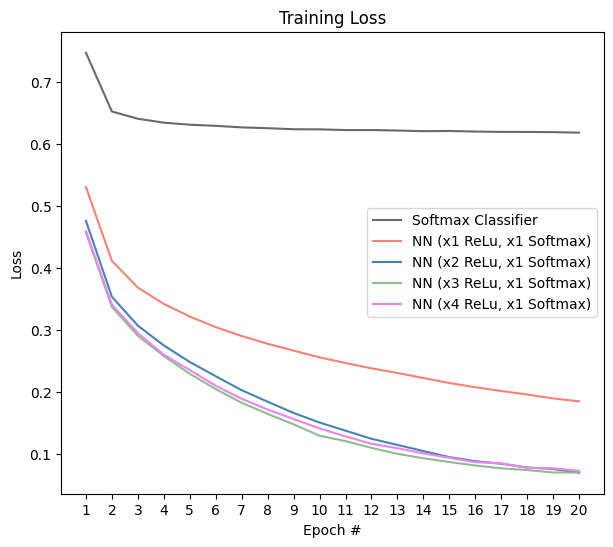

In [30]:
# Plot the training loss of the models
plot_models_loss(models, labels, loss='Training', n_epochs=20, save_fig=False)

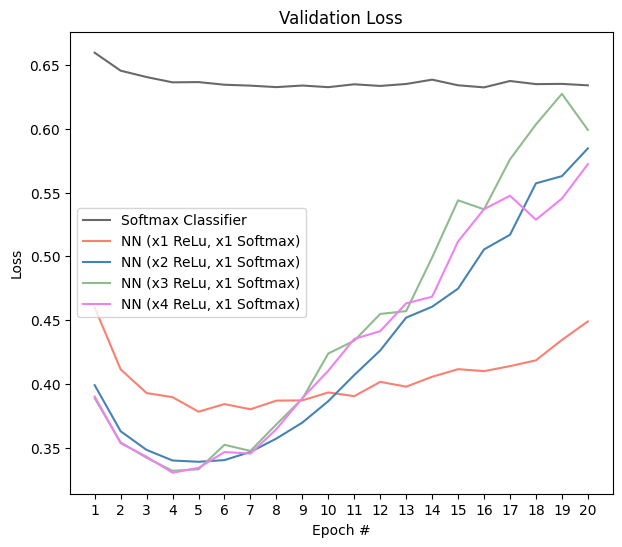

In [31]:
# Plot the validation loss of the models
plot_models_loss(models, labels, loss='Validation', n_epochs=20, save_fig=False)

## Part 2: Dropout Regularization

In our experiments, we found that values greater than 0.5 slowed down the optimization and they made the models so simple that the algorithms were not able to learn as much as they could. On the other hand, values lower than 0.3 weren't enough to overcome overfitting. 

### 4 Layers (ReLu + Softmax) + Regularization (p=0.5)

In [32]:
# L1 600 Neurons L2 400 Neurons L3 200 Neurons L4 SoftMax

model = tf.keras.Sequential([
    layers.Dense(600, activation=tf.nn.relu, input_shape=trainX[1,:].shape),
    layers.Dropout(0.5),
    layers.Dense(400, activation=tf.nn.relu),
    layers.Dropout(0.5),
    layers.Dense(200, activation=tf.nn.relu),
    layers.Dropout(0.5),
    layers.Dense(len(unique_classes), activation=tf.nn.softmax)
])

n_epochs = 20

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

do_four_history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=256, validation_split=0.1)

Epoch 1/20
704/704 [==============================] - 2s 3ms/step - loss: 0.6562 - accuracy: 0.8034 - val_loss: 0.4792 - val_accuracy: 0.8550
Epoch 2/20
704/704 [==============================] - 2s 3ms/step - loss: 0.5138 - accuracy: 0.8464 - val_loss: 0.4391 - val_accuracy: 0.8723
Epoch 3/20
704/704 [==============================] - 2s 3ms/step - loss: 0.4753 - accuracy: 0.8575 - val_loss: 0.4143 - val_accuracy: 0.8769
Epoch 4/20
704/704 [==============================] - 2s 3ms/step - loss: 0.4520 - accuracy: 0.8641 - val_loss: 0.4027 - val_accuracy: 0.8804
Epoch 5/20
704/704 [==============================] - 2s 3ms/step - loss: 0.4351 - accuracy: 0.8689 - val_loss: 0.3856 - val_accuracy: 0.8863
Epoch 6/20
704/704 [==============================] - 2s 3ms/step - loss: 0.4197 - accuracy: 0.8729 - val_loss: 0.3782 - val_accuracy: 0.8897
Epoch 7/20
704/704 [==============================] - 2s 3ms/step - loss: 0.4116 - accuracy: 0.8754 - val_loss: 0.3636 - val_accuracy: 0.8907
Epoch 

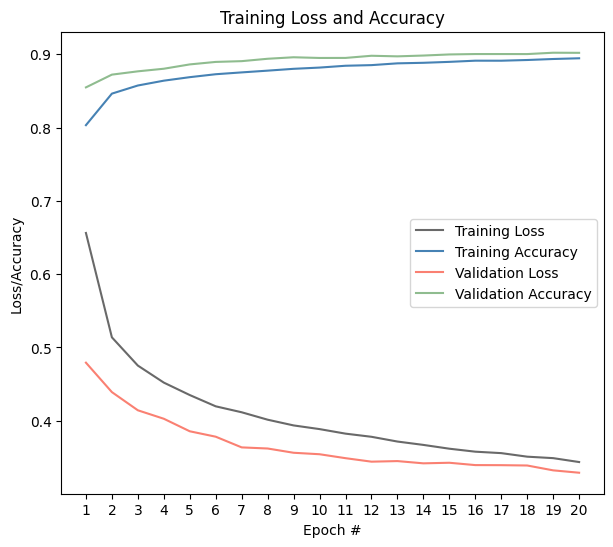

In [33]:
# Plot a linechart illustrating the NN's learning curves
plot_training_data(do_four_history, n_epochs, save_fig=False)

532/532 [==============================] - 1s 2ms/step - loss: 0.2670 - accuracy: 0.9209
 
****** SUMMARY REPORT ******
---------------------------
Loss on test set: 0.267
Accuracy on test set: 0.921
---------------------------
**** Confusion Matrix ****
 


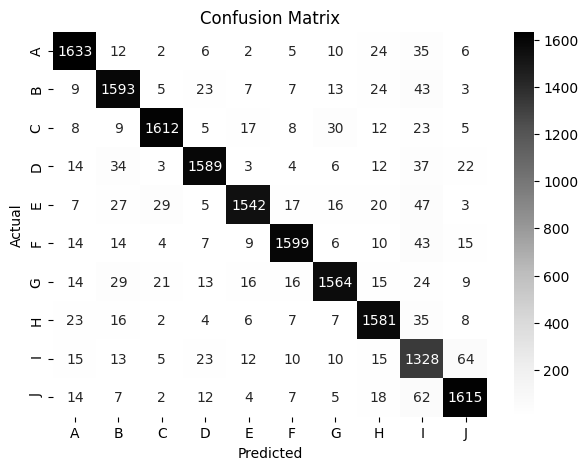

In [34]:
softmax_output = model.predict(testX) # Get the raw output of the network (softmax probabilities)
predicted_class = np.argmax(softmax_output, axis=1) # Store the class with highest probability
predicted_probability = np.amax(softmax_output, axis=1)  # Store the probability of the predicted class
result = model.evaluate(testX, testY) # Evaluate the model with Keras
summary_report(result, testY, predicted_class, save_fig=False) # Print the custom summary report

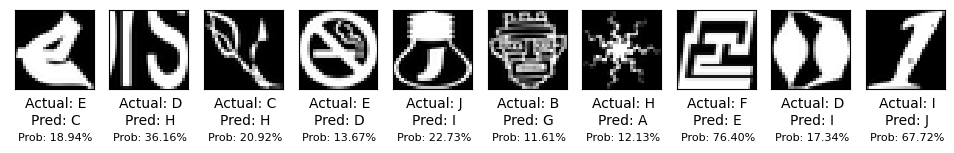

In [35]:
# Plot random 10 examples of misclassified images (you can run this cell muultiple times to see different examples)
plot_misclassified_images(10, predicted_class, predicted_probability, testX, testY, save_fig=False)

### 5 Layers (ReLu + Softmax) + Regularization (p=0.5)

In [36]:
# L1 800 Neurons L2 600 Neurons L3 400 Neurons L4 200 Neurons L5 SoftMax

model = tf.keras.Sequential([
    layers.Dense(800, activation=tf.nn.relu, input_shape=trainX[1,:].shape),
    layers.Dropout(0.5),
    layers.Dense(600, activation=tf.nn.relu, input_shape=trainX[1,:].shape),
    layers.Dropout(0.5),
    layers.Dense(400, activation=tf.nn.relu),
    layers.Dropout(0.5),
    layers.Dense(200, activation=tf.nn.relu),
    layers.Dropout(0.5),
    layers.Dense(len(unique_classes), activation=tf.nn.softmax)
])

n_epochs = 20

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

do_five_history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=256, validation_split=0.1)

Epoch 1/20
704/704 [==============================] - 3s 4ms/step - loss: 0.6824 - accuracy: 0.7954 - val_loss: 0.4853 - val_accuracy: 0.8543
Epoch 2/20
704/704 [==============================] - 2s 3ms/step - loss: 0.5212 - accuracy: 0.8465 - val_loss: 0.4348 - val_accuracy: 0.8704
Epoch 3/20
704/704 [==============================] - 2s 3ms/step - loss: 0.4843 - accuracy: 0.8565 - val_loss: 0.4222 - val_accuracy: 0.8759
Epoch 4/20
704/704 [==============================] - 2s 4ms/step - loss: 0.4625 - accuracy: 0.8627 - val_loss: 0.3973 - val_accuracy: 0.8821
Epoch 5/20
704/704 [==============================] - 3s 4ms/step - loss: 0.4442 - accuracy: 0.8690 - val_loss: 0.3901 - val_accuracy: 0.8845
Epoch 6/20
704/704 [==============================] - 2s 3ms/step - loss: 0.4324 - accuracy: 0.8714 - val_loss: 0.3852 - val_accuracy: 0.8871
Epoch 7/20
704/704 [==============================] - 2s 3ms/step - loss: 0.4221 - accuracy: 0.8747 - val_loss: 0.3830 - val_accuracy: 0.8875
Epoch 

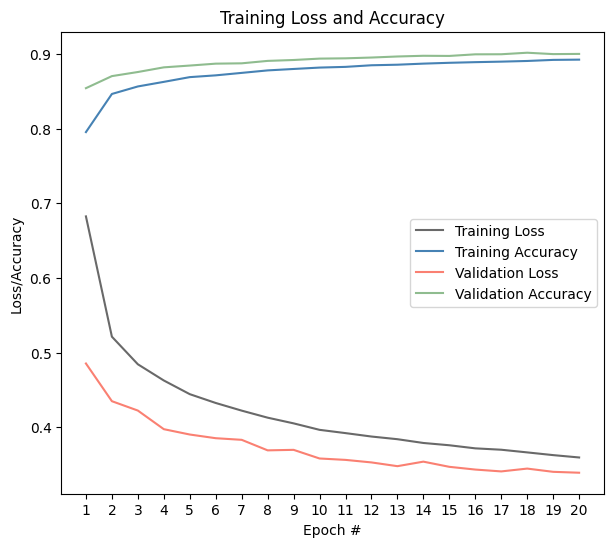

In [37]:
# Plot a linechart illustrating the NN's learning curves
plot_training_data(do_five_history, n_epochs, save_fig=False)

532/532 [==============================] - 1s 2ms/step - loss: 0.2727 - accuracy: 0.9195
 
****** SUMMARY REPORT ******
---------------------------
Loss on test set: 0.273
Accuracy on test set: 0.92
---------------------------
**** Confusion Matrix ****
 


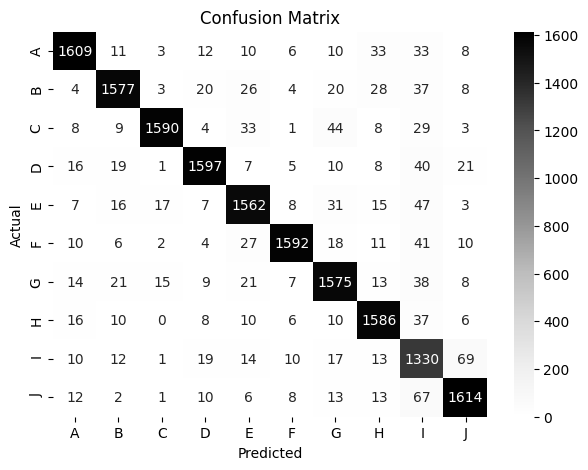

In [38]:
softmax_output = model.predict(testX) # Get the raw output of the network (softmax probabilities)
predicted_class = np.argmax(softmax_output, axis=1) # Store the class with highest probability
predicted_probability = np.amax(softmax_output, axis=1)  # Store the probability of the predicted class
result = model.evaluate(testX, testY) # Evaluate the model with Keras
summary_report(result, testY, predicted_class, save_fig=False) # Print the custom summary report

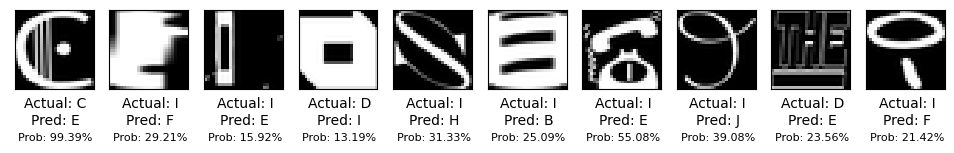

In [39]:
# Plot random 10 examples of misclassified images (you can run this cell muultiple times to see different examples)
plot_misclassified_images(10, predicted_class, predicted_probability, testX, testY, save_fig=False)